In [1]:
import sys
from pathlib import Path
import re

In [2]:
# Add parent directory (../) to sys.path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [ ]:
sys.path.append(os.path.join('....'))


In [3]:
from data_helpers import load_preprocessed_samples

In [4]:
# DATA_DIRECTORY = "../results/preprocessed_all"
DATA_DIRECTORY = "/home/swolf/asim_shared/preprocessed_data/downsample_freq=32,window_size=3600_0,stride=1800_0"

In [5]:
match = re.search(r"downsample_freq=(\d+)", DATA_DIRECTORY)
downsample_freq: int = int(match.group(1))

In [11]:
samples, labels = load_preprocessed_samples(data_dir=DATA_DIRECTORY, max_loaded_files=350)

Amount empty or corrupted files 0.


In [12]:
samples.__len__()

2451

In [8]:
labels.__len__()

1747

In [9]:
sum(labels)

95

In [10]:
amount_samples : int = 10000

In [11]:
example_samples = samples[:amount_samples]

In [12]:
from matrix_profile import MatrixProfile

In [13]:
# Calc MP using gpu
# nvidia-smi -l 8
matrix_profiles = []
counter:int = 0
subsequence_length:int = downsample_freq*10 # Assuming seizure of max. 10 sec
for s in example_samples[:3]:
    matrix_profiles.append(MatrixProfile.calculate_matrix_profile_for_sample_gpu(sample=s, subsequence_length=subsequence_length))
    counter +=1
    if counter % 1 == 0:
        print(counter)

/home/jhagenbe_sw/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


1
2
3


GPU: 3 samples = 2 min 6s

In [14]:
matrix_profiles = []
counter:int = 0
subsequence_length:int = downsample_freq*10 # Assuming seizure of max. 10 sec
for s in example_samples[:3]:
    matrix_profiles.append(MatrixProfile.calculate_matrix_profile_for_sample(sample=s, subsequence_length=subsequence_length))
    counter +=1
    if counter % 1 == 0:
        print(counter)

1
2
3


### Note:
- 5 samples = 1 min
- 10 samples = 2 min 30 => 15 sec per
- 17k samples = 4k min => ca. 3 Tage

In [ ]:
# Train Test Split
X_train = matrix_profiles[:int(0.8*amount_samples)]
y_train = labels[:int(0.8*amount_samples)]
X_test = matrix_profiles[int(0.8*amount_samples):]
y_test = labels[int(0.8*amount_samples):amount_samples]

In [ ]:
y_train = np.array(y_train, dtype=np.float32)
print(y_train.shape)  

y_test = np.array(y_test, dtype=np.float32)
print(y_test.shape)  

X_train = np.stack(X_train).astype(np.float32)
print(X_train.shape)

X_test = np.stack(X_test).astype(np.float32)
print(X_test.shape)  

In [ ]:
print(sum(y_test))
print(sum(y_train))

30
35


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-11 17:37:18.110826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from keras_cv.losses import FocalLoss
from tensorflow.keras.metrics import AUC

In [ ]:
def build_lstm_model(input_shape: tuple) -> tf.keras.Model:
    """
    Builds and compiles an LSTM model for binary classification of time series data.

    Args:
        input_shape (tuple): Shape of each input sample (timesteps, features).

    Returns:
        tf.keras.Model: Compiled LSTM model.
    """
    model = models.Sequential([
        # layers.Masking(mask_value=0.0, input_shape=input_shape),
        # layers.LSTM(64, return_sequences=False),
        layers.LSTM(64, return_sequences=False, input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    # Instantiate focal loss
    focal = FocalLoss(
        alpha=0.85,  
        gamma=2.0,   
        from_logits=False,  
        reduction="auto"    
    )
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(
        optimizer='adam',
        loss=focal,
        metrics=[AUC(name="auc")]
    )

    return model


def evaluate_predictions(y_true: np.ndarray, y_pred_prob: np.ndarray) -> None:
    """
    Calculates and plots common classification metrics.

    Args:
        y_true (np.ndarray): Ground truth binary labels.
        y_pred_prob (np.ndarray): Predicted probabilities for class 1.
    """
    y_pred = (y_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_predictions(y_true, y_pred_prob)
    plt.title("ROC Curve")
    plt.show()

In [ ]:
model = build_lstm_model(input_shape=(3746, 4))

model.fit(
    X_train,
    y_train,
    # validation_split=0.1,
    epochs=3,
    batch_size=32,
    class_weight={0: 1.0, 1: 57.},
    verbose=1
)

Epoch 1/3
250/250 [==============================] - 29s 106ms/step - loss: 0.1551 - auc: 0.4194
Epoch 2/3
250/250 [==============================] - 27s 107ms/step - loss: 0.0738 - auc: 0.4296
Epoch 3/3
250/250 [==============================] - 27s 107ms/step - loss: 0.0664 - auc: 0.4643


63/63 [==============================] - 3s 38ms/step
Accuracy:  0.0275
Precision: 0.0152
Recall:    1.0000
F1-Score:  0.0299
ROC-AUC:   0.4464


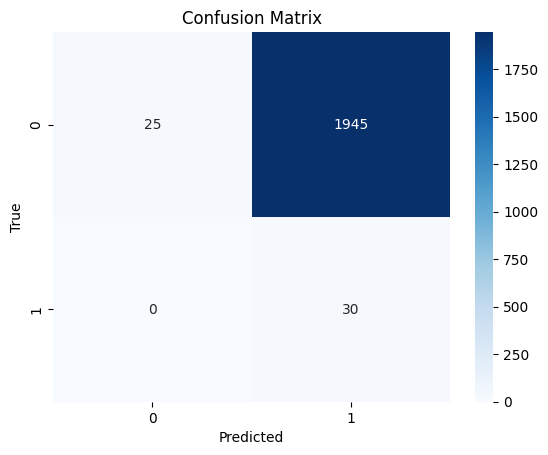

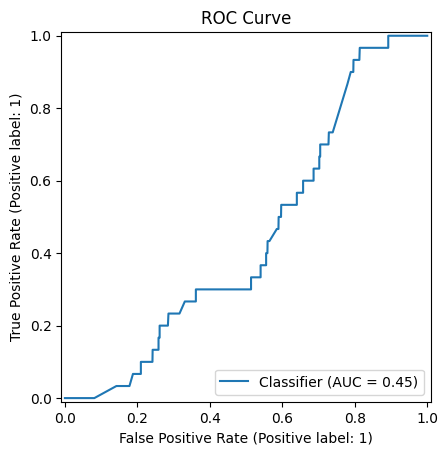

In [ ]:
y_pred_prob = model.predict(X_test).flatten()
evaluate_predictions(y_test, y_pred_prob)

63/63 [==============================] - 4s 60ms/step
Accuracy:  0.3750
Precision: 0.0204
Recall:    0.8667
F1-Score:  0.0399
ROC-AUC:   0.6454


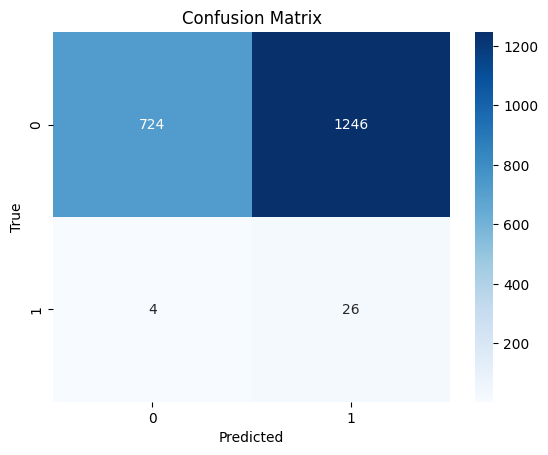

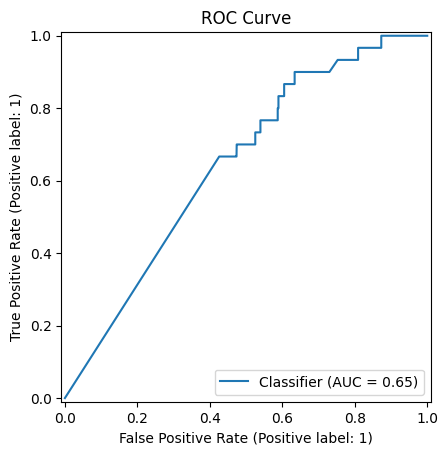

In [ ]:
y_pred_prob = model.predict(X_test).flatten()
evaluate_predictions(y_test, y_pred_prob)